In [ ]:
!pip install gurobipy

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

In [ ]:
stocks19 = pd.read_csv('stocks2019.csv', index_col=0).drop(columns=['NDX'])
stocks20 = pd.read_csv('stocks2020.csv', index_col=0).drop(columns=['NDX'])

In [ ]:
stocks19.iloc[:5]

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,82.851608,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,77.846962,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,79.736969,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,80.238388,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,82.195892,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [ ]:
returns19 = stocks19.pct_change().dropna(how="all")
returns20 = stocks20.pct_change().dropna(how="all")
returns19.iloc[:5]

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


In [ ]:
returns_np = returns19.values
N, n = returns_np.shape
beta = 0.95
R = 0.0002  # Minimum required average daily return

# Calculate daily mean returns for each stock
mean_returns = returns_np.mean(axis=0)

# === GUROBI MODEL ===
m = gp.Model("minimize_CVaR")

# Variables
x = m.addMVar(n, lb=0, ub=1, name="weights")
alpha = m.addVar(lb=-GRB.INFINITY, name="VaR")
z = m.addMVar(N, lb=0, name="aux_shortfall")  # z_t >= 0

# Constraints
m.addConstr(x.sum() == 1, name="weights_sum")
m.addConstr(x @ mean_returns >= R, name="min_mean_return")
m.addConstrs((z[t] >= -returns_np[t, :] @ x - alpha for t in range(N)), name="shortfall")

# Objective
obj = alpha + (1/(N*(1-beta))) * z.sum()
m.setObjective(obj, GRB.MINIMIZE)

# Solve
m.Params.OutputFlag = 0
m.optimize()

# Parameters from optimization (expressed as percentages)
mean_return = x.X @ mean_returns * 100
VaR = alpha.X * 100
CVaR = m.objVal * 100

# Results
print("Optimal weights:", x.X)
print("Optimal mean return:", round(mean_return, 2), "%")
print("Optimal VaR (alpha):", round(-VaR, 2), "%")
print("Optimal CVaR:", round(-CVaR, 2), "%")

Restricted license - for non-production use only - expires 2026-11-23
Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.08076593 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.26496489 0.0626959  0.         0.         0.06561376 0.01963614
 0.         0.         0.03035228 0.03431195 0.         0.
 0.         0.02348597 0.         0.05215454 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01978987 0.         0.04050981
 0.         0.         0.         0.00180162 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

In [ ]:
weights = pd.DataFrame([x.X], columns=returns19.columns)
weights.iloc[-5:]

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080766,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303917,0.0


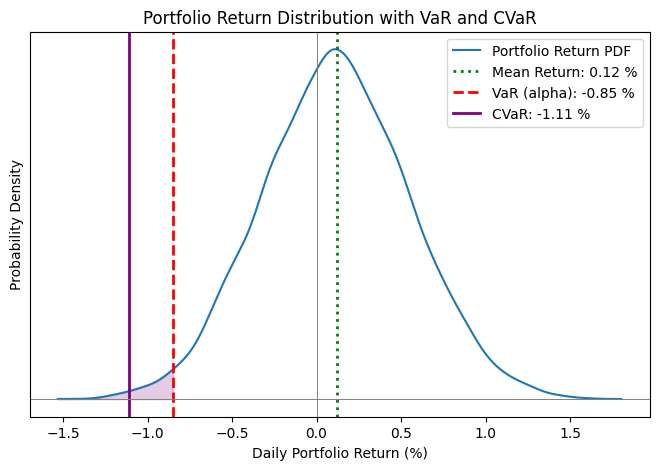

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import norm

z_beta = norm.ppf(beta)  # Quantile for the standard normal distribution
scale = (VaR - mean_return) / z_beta

# Generate simulated returns centered at mean_return
np.random.seed(0)
simulated_returns = np.random.normal(loc=mean_return, scale=scale, size=10000)

# Kernel density estimate for probability density function (pdf)
kde = gaussian_kde(simulated_returns)
x_vals = np.linspace(min(simulated_returns), max(simulated_returns), 1000)
pdf_vals = kde(x_vals)

# Plot the pdf
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Portfolio Return PDF')

# Mark lines
plt.axvline(mean_return, color='g', linestyle=':', linewidth=2, label=f'Mean Return: {mean_return:.2f} %') # Mark mean return
plt.axvline(-VaR, color='r', linestyle='--', linewidth=2, label=f'VaR (alpha): {-VaR:.2f} %') # Mark VaR (quantile point)
plt.axvline(-CVaR, color='purple', linestyle='-', linewidth=2, label=f'CVaR: {-CVaR:.2f} %') # Mark CVaR (expected tail loss)

# Shade tail region (returns <= VaR)
x_fill = x_vals[x_vals <= -VaR]
plt.fill_between(x_fill, 0, kde(x_fill), color='purple', alpha=0.2)

plt.title('Portfolio Return Distribution with VaR and CVaR')
plt.xlabel('Daily Portfolio Return (%)')
plt.ylabel('Probability Density')
ax = plt.gca()
ax.yaxis.set_ticks([])
ax.set_yticklabels([])
ax.grid(False)
ax.axhline(0, color='gray', linestyle='-', linewidth=0.7)
ax.axvline(0, color='gray', linestyle='-', linewidth=0.7)

plt.legend()
plt.show()